# long-short-portfolio

On the first trading day of every month, rebalance portfolio to given percentages.  One of the positions is a short position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Define Portfolios

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
portfolio_option = {'SPY': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}

directions = {'SPY': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}

Some global data

In [4]:
symbols = list(portfolio_option.keys())
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

In [5]:
options = {
    'use_adj' : True,
    'use_cache' : True,
}
options

{'use_adj': True, 'use_cache': True}

In [6]:
# Fetch timeseries
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, fields=['close'],
                                use_cache=options['use_cache'], use_adj=options['use_adj'])
# Add calendar columns
ts = portfolio.calendar(ts)

# Finalize timeseries
ts, start = portfolio.finalize_timeseries(ts, start)

# Init trade logs
portfolio.init_trade_logs(ts)

In [7]:
pf.TradeLog.cash = capital

# Trading algorithm
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)
    
    # Rebalance on the first trading day of each month
    if row.first_dotm or end_flag:

        #portfolio.print_holdings(date, row)
        
        # If last row, then zero out all weights.  Otherwise use portfolio_option weights.
        weights = portfolio_option if not end_flag else pf.set_dict_values(portfolio_option, 0)

        # Get closing prices for all symbols
        p = portfolio.get_prices(row, fields=['close'])
        prices = {symbol:p[symbol]['close'] for symbol in portfolio.symbols}
        
        # Adjust weights of all symbols in portfolio
        portfolio.adjust_percents(date, prices, weights, row, directions)

    # Record daily balance.
    portfolio.record_daily_balance(date, row)

In [8]:
# Get logs
rlog, tlog, dbal = portfolio.get_logs()

In [9]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,50.23,19,entry,SHRT,TLT_SHRT
1,2004-12-01,1,85.67,58,entry,LONG,SPY
2,2004-12-01,2,50.23,59,entry,LONG,TLT
3,2004-12-01,3,45.38,22,entry,LONG,GLD
4,2005-01-03,4,51.75,1,exit,LONG,TLT
5,2005-01-03,5,43.02,1,entry,LONG,GLD
6,2005-02-01,6,53.40,2,exit,LONG,TLT
7,2005-02-01,7,53.40,1,exit,SHRT,TLT_SHRT
8,2005-03-01,8,52.68,1,entry,LONG,TLT
9,2005-03-01,9,52.68,1,entry,SHRT,TLT_SHRT


In [10]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
315,2015-06-01,104.61,2021-07-01,142.72,38.11,38.11,1,18526.68,LONG,TLT
316,2015-07-01,100.08,2021-07-01,142.72,42.65,42.65,1,18569.33,LONG,TLT
317,2015-08-03,104.10,2021-01-04,182.33,78.23,78.23,1,18647.56,LONG,GLD
318,2015-08-03,104.10,2021-06-01,177.90,73.80,73.80,1,18721.36,LONG,GLD
319,2015-09-01,171.07,2021-08-20,443.36,272.29,816.88,3,19538.23,LONG,SPY
...,...,...,...,...,...,...,...,...,...,...
410,2021-04-01,135.56,2021-08-20,149.22,13.66,40.99,3,27218.71,LONG,TLT
411,2021-05-03,136.75,2021-08-20,149.22,12.47,24.93,2,27243.65,LONG,TLT
412,2021-06-01,136.64,2021-08-20,149.22,-12.58,-12.58,1,27231.07,SHRT,TLT_SHRT
413,2021-06-01,136.64,2021-08-20,149.22,12.58,12.58,1,27243.65,LONG,TLT


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-08-16,40078.01,40078.01,40078.01,173,1903.49,1.00,-
2021-08-17,39937.26,39937.26,39937.26,173,1903.49,1.00,-
2021-08-18,39747.82,39747.82,39747.82,173,1903.49,1.00,-
2021-08-19,39824.93,39824.93,39824.93,173,1903.49,1.00,-
2021-08-20,37244.65,37244.65,37244.65,0,37244.65,1.00,X


In [12]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2021-08-20
beginning_balance                                           10000
ending_balance                                           37244.65
total_net_profit                                         27244.65
gross_profit                                             30222.53
gross_loss                                               -2977.89
profit_factor                                               10.15
return_on_initial_capital                                  272.45
annual_return_rate                                           8.16
trading_period                           16 years 9 months 2 days
pct_time_in_market                                          99.81
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

,cumul_total,weight,pct_cumul_total,relative_performance
TLT_SHRT,"-$2,162.96",0.10,-0.08,-0.79
SPY,"$20,546.99",0.50,0.75,1.51
TLT,"$6,592.14",0.30,0.24,0.81
GLD,"$2,268.47",0.10,0.08,0.83
TOTAL,"$27,244.65",1.00,1.00,1.00


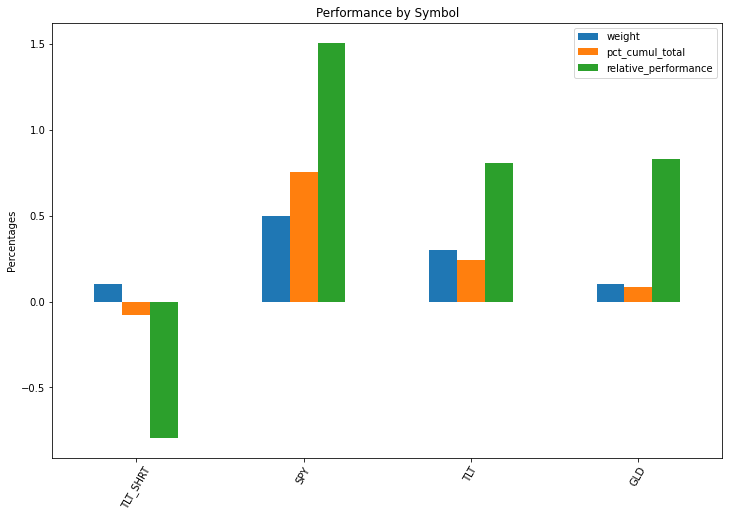

In [13]:
totals = portfolio.performance_per_symbol(portfolio_option)
totals

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

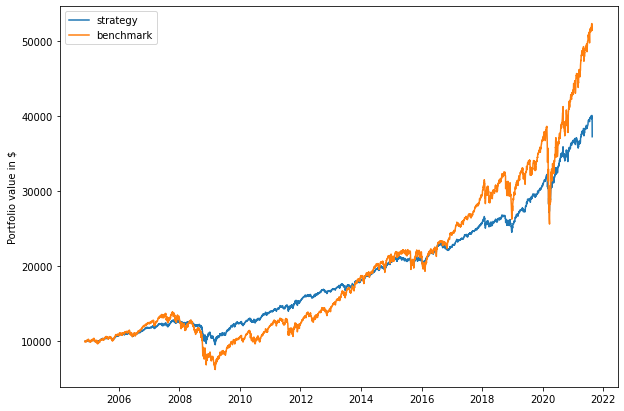

In [15]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

In [16]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$37,244.65","$51,890.36"
total_net_profit,"$27,244.65","$41,890.36"
gross_profit,"$30,222.53","$41,890.36"
gross_loss,"-$2,977.89",$0.00


,strategy,benchmark
annual_return_rate,8.16,10.33
max_closed_out_drawdown,-25.72,-55.12
annualized_return_over_max_drawdown,0.32,0.19
best_month,14.21,23.56
worst_month,-15.72,-30.97
sharpe_ratio,0.92,0.61
sortino_ratio,1.12,0.72
monthly_std,2.23,4.51
annual_std,7.77,16.27


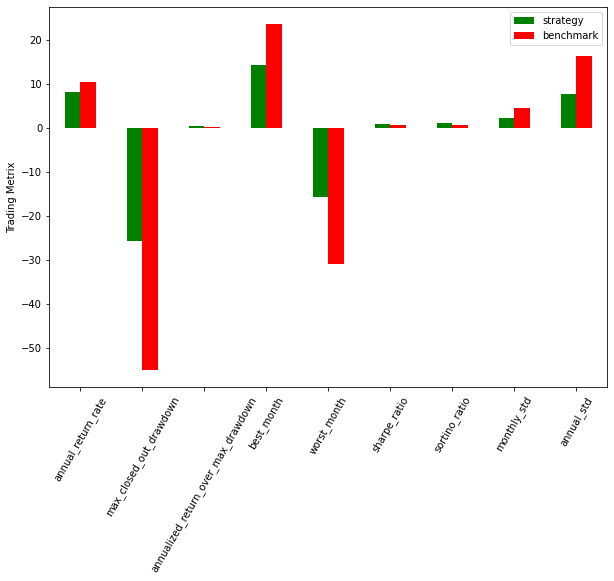

In [17]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df